In [191]:

'''
This is a file for final combine strategy and backtest result plot.
'''
import numpy as np
import pandas
import vectorbt as vbt
data = pandas.read_csv('./data/BTCUSDT_1h.csv')
data = data.set_index('close_time')
data=data[(data.index < '2022-09-01')]
# data=data[ (data.index>'2022-08-31')&(data.index < '2023-07-01')]
data.index = pandas.to_datetime(data.index)
RSI = vbt.IndicatorFactory.from_talib("RSI")
STOCH = vbt.IndicatorFactory.from_talib("STOCH")

In [193]:
train_end = '2022-08-30'
BENCHMARK='benchmark'

In [194]:
'''
implement long top five parameter strategy
'''
import numpy as np
import vectorbt as vbt
from numba import njit
@njit
def cross_above(a, b):
    return (a[:-1] <= b[:-1]) & (a[1:] > b[1:])

@njit
def cross_below(a, b):
    return (a[:-1] >= b[:-1]) & (a[1:] < b[1:])

@njit
def produce_signal(rsi_values, slowk_values, slowd_values):
    cross = cross_above(slowk_values, slowd_values)
    trend = np.zeros(len(rsi_values), dtype=np.int32)
    for i in range(1, len(rsi_values)):
        if rsi_values[i] > 60 and cross[i-1] :
            trend[i] = 1
        elif rsi_values[i] < 40:
            trend[i] = -1

    return trend


def custom_indicator(close, high, low, rsi_window=32, fastk_period=9, slowk_period=3,slowd_period=3):
    # Calculate RSI
    rsi = RSI.run(close, rsi_window).real
    # Calculate Stochastic Oscillator
    stoch = STOCH.run(
        high,
        low,
        close,
        fastk_period=fastk_period,
        slowk_period=slowk_period,
        slowk_matype=0,
        slowd_period=slowd_period,
        slowd_matype=0
    )

    # Convert to numpy arrays
    rsi_values = rsi.to_numpy()
    slowk_values = stoch.slowk.to_numpy()
    slowd_values = stoch.slowd.to_numpy()

    # Ensure no NaNs
    rsi_values = np.nan_to_num(rsi_values)
    slowk_values = np.nan_to_num(slowk_values)
    slowd_values = np.nan_to_num(slowd_values)

    return produce_signal(rsi_values,slowk_values,slowd_values)

# Define the custom indicator using IndicatorFactory
ind = vbt.IndicatorFactory(
    class_name="Combination",
    short_name="comb",
    input_names=['close', 'high', 'low'],
    param_names=['rsi_window', 'fastk_period', 'slowk_period', 'slowd_period'],
    output_names=["value"]
).from_apply_func(
    custom_indicator,
    rsi_window=32,
    fastk_period=9,
    slowk_period=3,
    slowd_period=3)

# Run the indicator
res = ind.run(
    data['close'],
    data['high'],
    data['low'],
    rsi_window=[32,33,33,32,32],
    fastk_period=[24,25,20,25,17],
    slowk_period=3,
    slowd_period=3,
)

# Generate entries and exits signals
entries = res.value == 1
exits = res.value == -1

# Create a portfolio from the signals
pf = vbt.Portfolio.from_signals(data['close'], entries, exits,freq='1h',direction='longonly',fees=0.05/100,sl_stop=0.05)
long_returns = pf.returns()



In [195]:
target_stats =  ["win_rate",
                "sharpe_ratio",
                "max_dd",
                "total_return",
                "profit_factor",
                "total_trades",
                "max_dd_duration",
                        ]
pf.stats(metrics = target_stats, agg_func=None)

Win Rate [%]  \
comb_rsi_window comb_fastk_period comb_slowk_period comb_slowd_period                 
32              24                3                 3                     42.372881   
33              25                3                 3                     43.859649   
                20                3                 3                     45.614035   
32              25                3                 3                     42.372881   
                17                3                 3                     45.762712   

                                                                       Sharpe Ratio  \
comb_rsi_window comb_fastk_period comb_slowk_period comb_slowd_period                 
32              24                3                 3                      1.896453   
33              25                3                 3                      1.906515   
                20                3                 3                      1.903491   
32              25                3                 3                      1.881951   
                17                3                 3                      1.893226   

                                                                       Max Drawdown [%]  \
comb_rsi_window comb_fastk_period comb_slowk_period comb_slowd_period                     
32              24                3                 3                         35.677815   
33              25                3                 3                         34.296260   
                20                3                 3                         29.901838   
32              25                3                 3                         36.279979   
                17                3                 3                         35.398490   

                                                                       Total Return [%]  \
comb_rsi_window comb_fastk_period comb_slowk_period comb_slowd_period                     
32              24                3                 3                        646.314742   
33              25                3                 3                        657.971353   
                20                3                 3                        655.319201   
32              25                3                 3                        631.730870   
                17                3                 3                        645.971456   

                                                                       Profit Factor  \
comb_rsi_window comb_fastk_period comb_slowk_period comb_slowd_period                  
32              24                3                 3                       1.782546   
33              25                3                 3                       1.835160   
                20                3                 3                       1.946956   
32              25                3                 3                       1.724586   
                17                3                 3                       1.761283   

                                                                       Total Trades  \
comb_rsi_window comb_fastk_period comb_slowk_period comb_slowd_period                 
32              24                3                 3                            59   
33              25                3                 3                            57   
                20                3                 3                            57   
32              25                3                 3                            59   
                17                3                 3                            59   

                                                                      Max Drawdown Duration  
comb_rsi_window comb_fastk_period comb_slowk_period comb_slowd_period                        
32              24                3                 3                     311 days 08:00:00  
33              25                3                 3             

In [164]:
'''
implement short top five parameter strategy
'''
import numpy as np
import pandas
import pandas as pd
import vectorbt as vbt
from numba import njit

@njit
def cross_above(a, b):
    return (a[:-1] <= b[:-1]) & (a[1:] > b[1:])

@njit
def cross_below(a, b):
    return (a[:-1] >= b[:-1]) & (a[1:] < b[1:])

@njit
def produce_signal(rsi_values, slowk_values, slowd_values):
    cross = cross_below(slowk_values,slowd_values)
    trend = np.zeros(len(rsi_values), dtype=np.int32)
    for i in range(1, len(rsi_values)):
        if rsi_values[i] < 40 and cross[i-1] :
            trend[i] = 1
        elif rsi_values[i] > 60:
            trend[i] = -1

    return trend


def custom_indicator(close, high, low, rsi_window=32, fastk_period=9, slowk_period=3,slowd_period=3):
    rsi = RSI.run(close, rsi_window).real     # Calculate RSI
    stoch = STOCH.run(    # Calculate Stochastic Oscillator
        high,
        low,
        close,
        fastk_period=fastk_period,
        slowk_period=slowk_period,
        slowk_matype=0,
        slowd_period=slowd_period,
        slowd_matype=0
    )

    # Convert to numpy arrays
    rsi_values = rsi.to_numpy()
    slowk_values = stoch.slowk.to_numpy()
    slowd_values = stoch.slowd.to_numpy()

    # Ensure no NaNs
    rsi_values = np.nan_to_num(rsi_values)
    slowk_values = np.nan_to_num(slowk_values)
    slowd_values = np.nan_to_num(slowd_values)

    return produce_signal(rsi_values,slowk_values,slowd_values)

# Define the custom indicator using IndicatorFactory
ind = vbt.IndicatorFactory(
    class_name="Combination",
    short_name="comb",
    input_names=['close', 'high', 'low'],
    param_names=['rsi_window', 'fastk_period', 'slowk_period', 'slowd_period'],
    output_names=["value"]
).from_apply_func(
    custom_indicator,
    rsi_window=32,
    fastk_period=9,
    slowk_period=3,
    slowd_period=3)

# Run the indicator
res = ind.run(
    data['close'],
    data['high'],
    data['low'],
    rsi_window=[49,49,49,49,49],
    fastk_period=[18,27,26,29,28],
    slowk_period=3,
    slowd_period=3,
)

# Generate entries and exits signals
entries = res.value == 1
exits = res.value == -1

# Create a portfolio from the signals
pf = vbt.Portfolio.from_signals(data['close'], entries, exits,freq='1h',direction='shortonly',fees=0.05/100,sl_stop=0.05)
tmp= pf.returns()
short_returns=pd.DataFrame(tmp.values,index=tmp.index,columns=tmp.columns)



In [165]:
target_stats =  ["win_rate",
                "sharpe_ratio",
                "max_dd",
                "total_return",
                "profit_factor",
                "total_trades",
                "max_dd_duration",
                        ]
pf.stats(metrics = target_stats, agg_func=None)

Win Rate [%]  \
comb_rsi_window comb_fastk_period comb_slowk_period comb_slowd_period                 
49              18                3                 3                          40.0   
                27                3                 3                          50.0   
                26                3                 3                          50.0   
                29                3                 3                          50.0   
                28                3                 3                          50.0   

                                                                       Sharpe Ratio  \
comb_rsi_window comb_fastk_period comb_slowk_period comb_slowd_period                 
49              18                3                 3                      0.326684   
                27                3                 3                      0.392015   
                26                3                 3                      0.403911   
                29                3                 3                      0.324540   
                28                3                 3                      0.317661   

                                                                       Max Drawdown [%]  \
comb_rsi_window comb_fastk_period comb_slowk_period comb_slowd_period                     
49              18                3                 3                         15.700918   
                27                3                 3                         15.289351   
                26                3                 3                         15.289351   
                29                3                 3                         15.289351   
                28                3                 3                         15.289351   

                                                                       Total Return [%]  \
comb_rsi_window comb_fastk_period comb_slowk_period comb_slowd_period                     
49              18                3                 3                          4.486134   
                27                3                 3                          6.142542   
                26                3                 3                          6.444884   
                29                3                 3                          4.433257   
                28                3                 3                          4.261938   

                                                                       Profit Factor  \
comb_rsi_window comb_fastk_period comb_slowk_period comb_slowd_period                  
49              18                3                 3                       1.257411   
                27                3                 3                       1.380254   
                26                3                 3                       1.404958   
                29                3                 3                       1.253271   
                28                3                 3                       1.241616   

                                                                       Total Trades  \
comb_rsi_window comb_fastk_period comb_slowk_period comb_slowd_period                 
49              18                3                 3                            10   
                27                3                 3                            10   
                26                3                 3                            10   
                29                3                 3                            10   
                28                3                 3                            10   

                                                                      Max Drawdown Duration  
comb_rsi_window comb_fastk_period comb_slowk_period comb_slowd_period                        
49              18                3                 3                     112 days 13:00:00  
                27                3                 3             

In [108]:
import matplotlib.pyplot as plt
def plot_cumsum(demo_ret, title = 'title'):
    fig, ax = plt.subplots(figsize=(24,8))
    ax.axvline(x= pd.to_datetime(train_end) , ymin=0, ymax=4.5)
    for col in demo_ret.columns:
        demo_ret[col].plot(ax=ax, label=col)
    plt.legend()
    plt.title(title)
    plt.show()

from scipy.optimize import minimize

UPPER_WEIGHT = 0.5

def max_sharpe(stras_return):
    def efficient_frontier(expected_returns, cov_matrix, risk_free_rate):
        num_assets = len(expected_returns)
        initial_weights = np.ones(num_assets) / num_assets  # Initial equal weights

        constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(np.abs(weights)) - 1})  # Sum of weights = 1

        bounds = tuple((0.05, UPPER_WEIGHT) for _ in range(num_assets))  # Each weight is between 0 and 1
        result = minimize(objective, initial_weights, args=(expected_returns, cov_matrix, risk_free_rate),
                          method='SLSQP', bounds=bounds, constraints=constraints)

        efficient_weights = result.x
        return efficient_weights

    def objective(weights, expected_returns, cov_matrix, risk_free_rate):
        portfolio_return = np.sum(expected_returns * weights)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std
        return -sharpe_ratio  # We minimize the negative of the Sharpe ratio to maximize it

    risk_free_rate = 0
    cov_matrix = stras_return.cov().values
    sharp_weight = efficient_frontier(stras_return.mean().values, cov_matrix, risk_free_rate)
    sharp_weight = pd.DataFrame(sharp_weight, index = stras_return.columns, columns = ['sharpe_weight']).T
    return sharp_weight



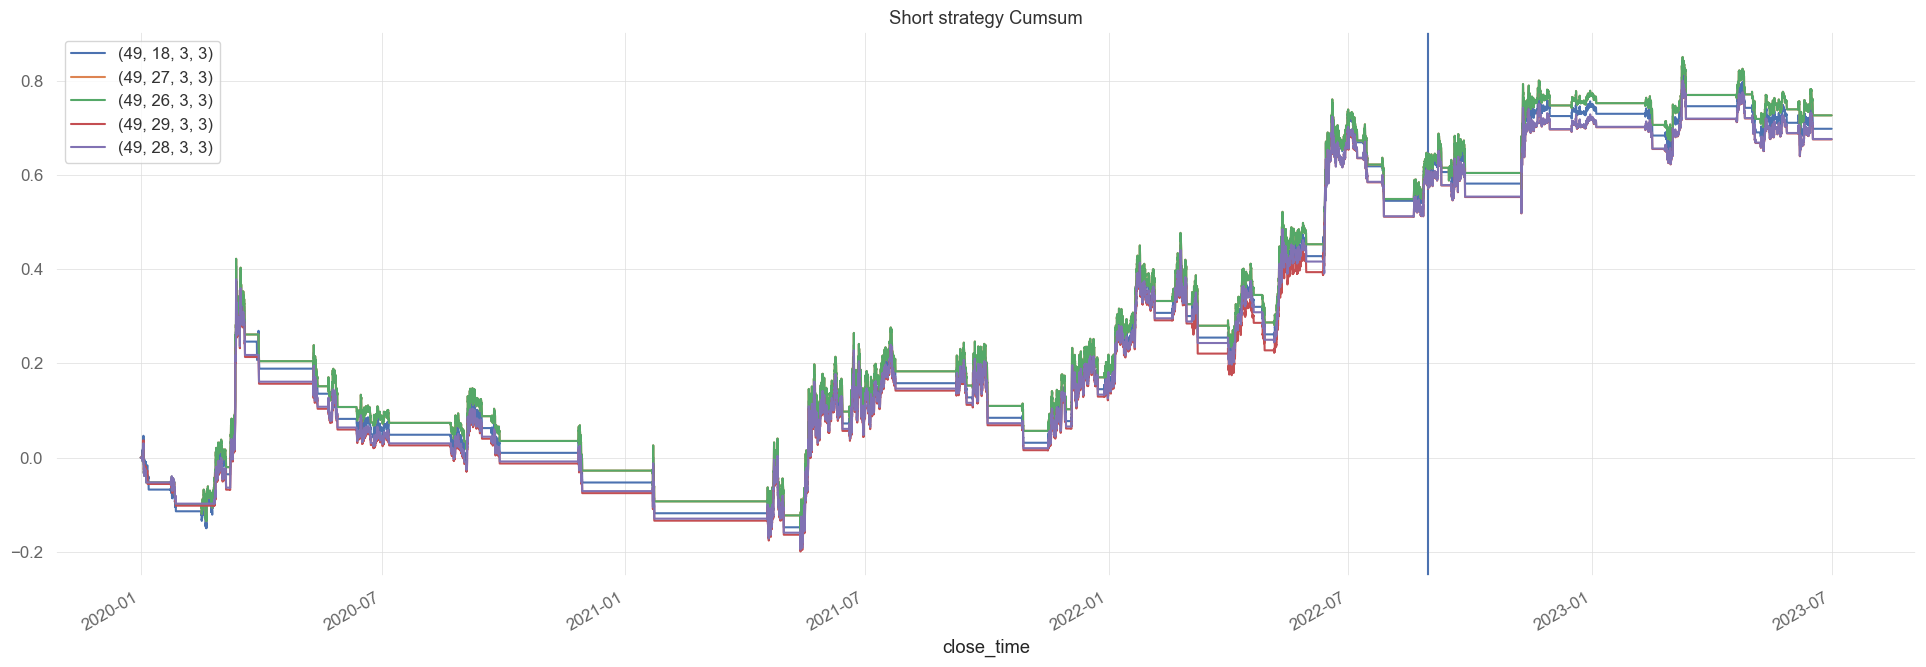

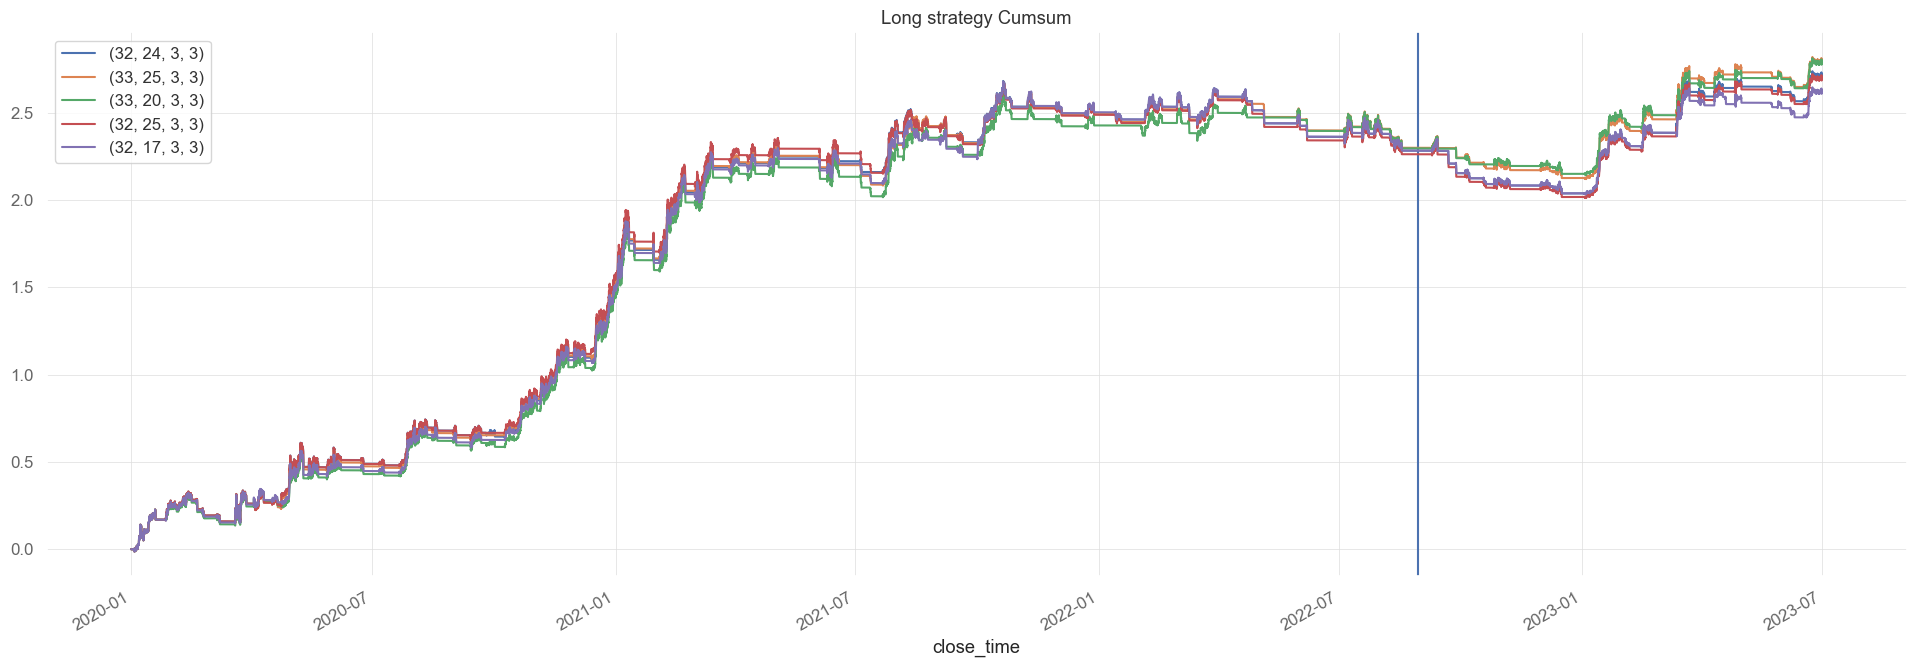

In [109]:
plot_cumsum(short_returns.cumsum(), title = 'Short strategy Cumsum')
plot_cumsum(long_returns.cumsum(), title = 'Long strategy Cumsum')

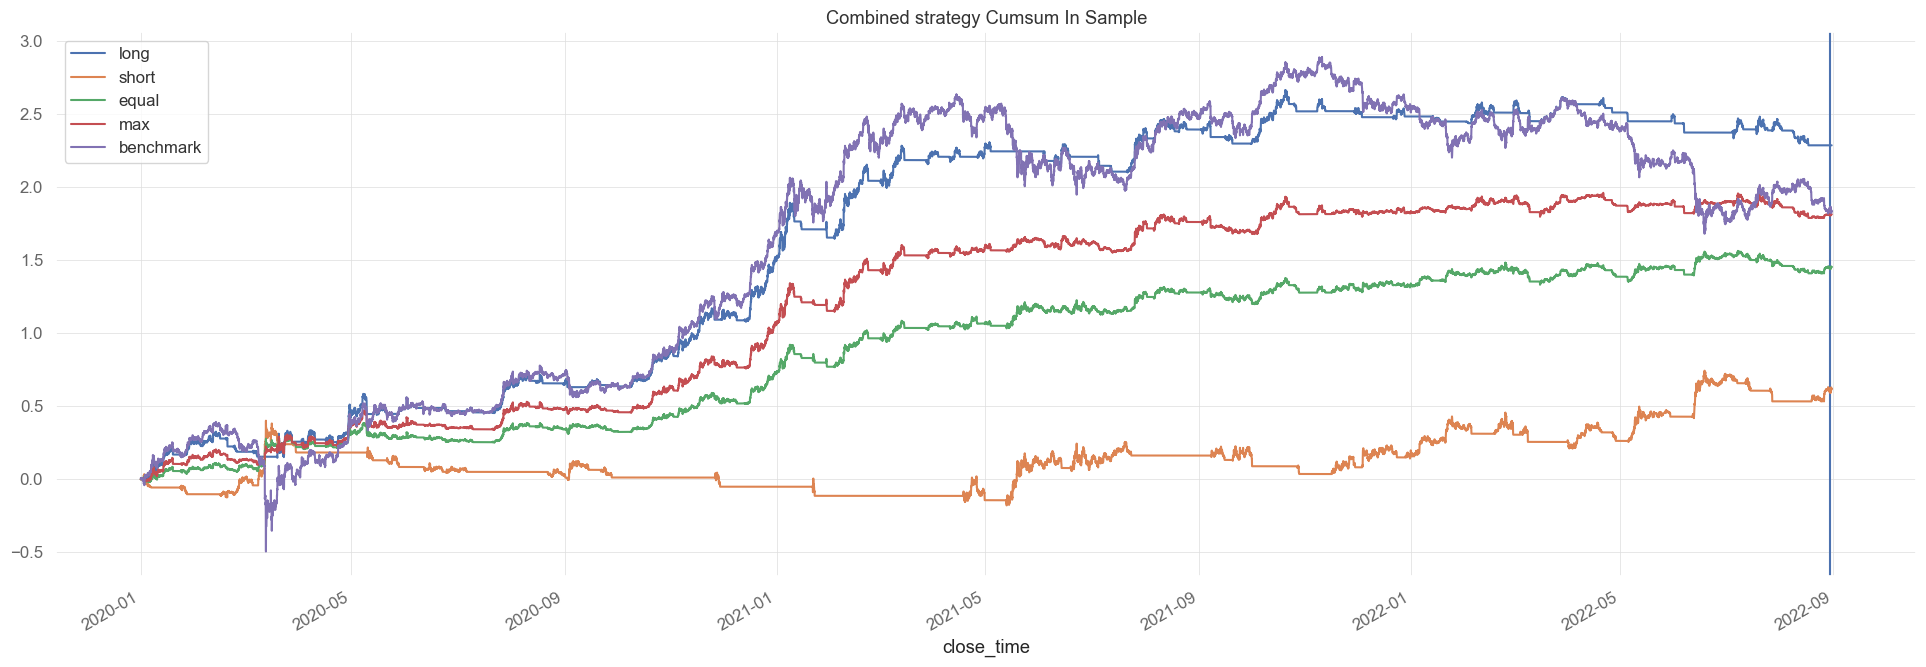

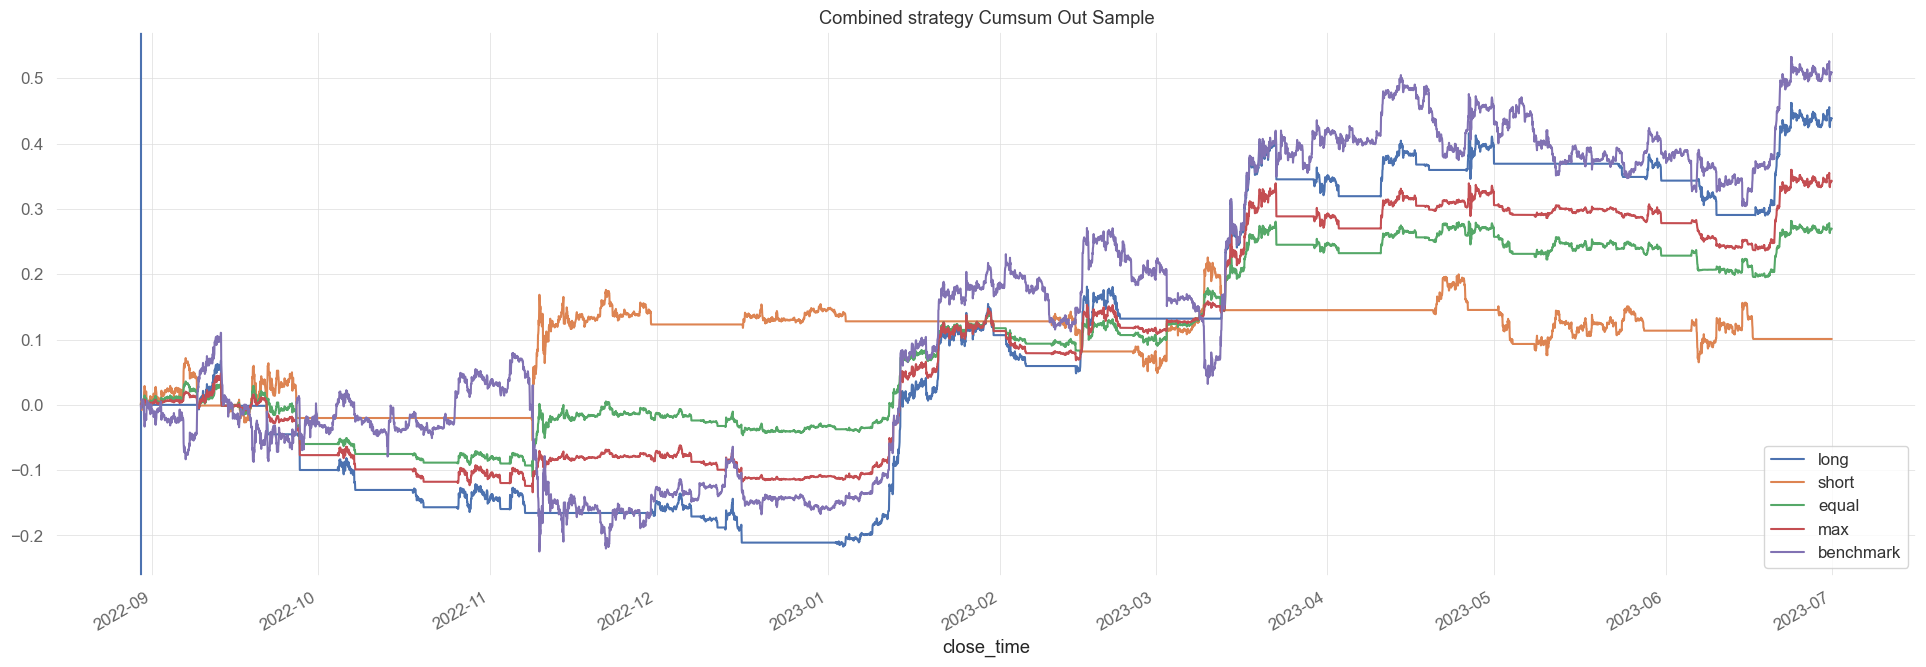

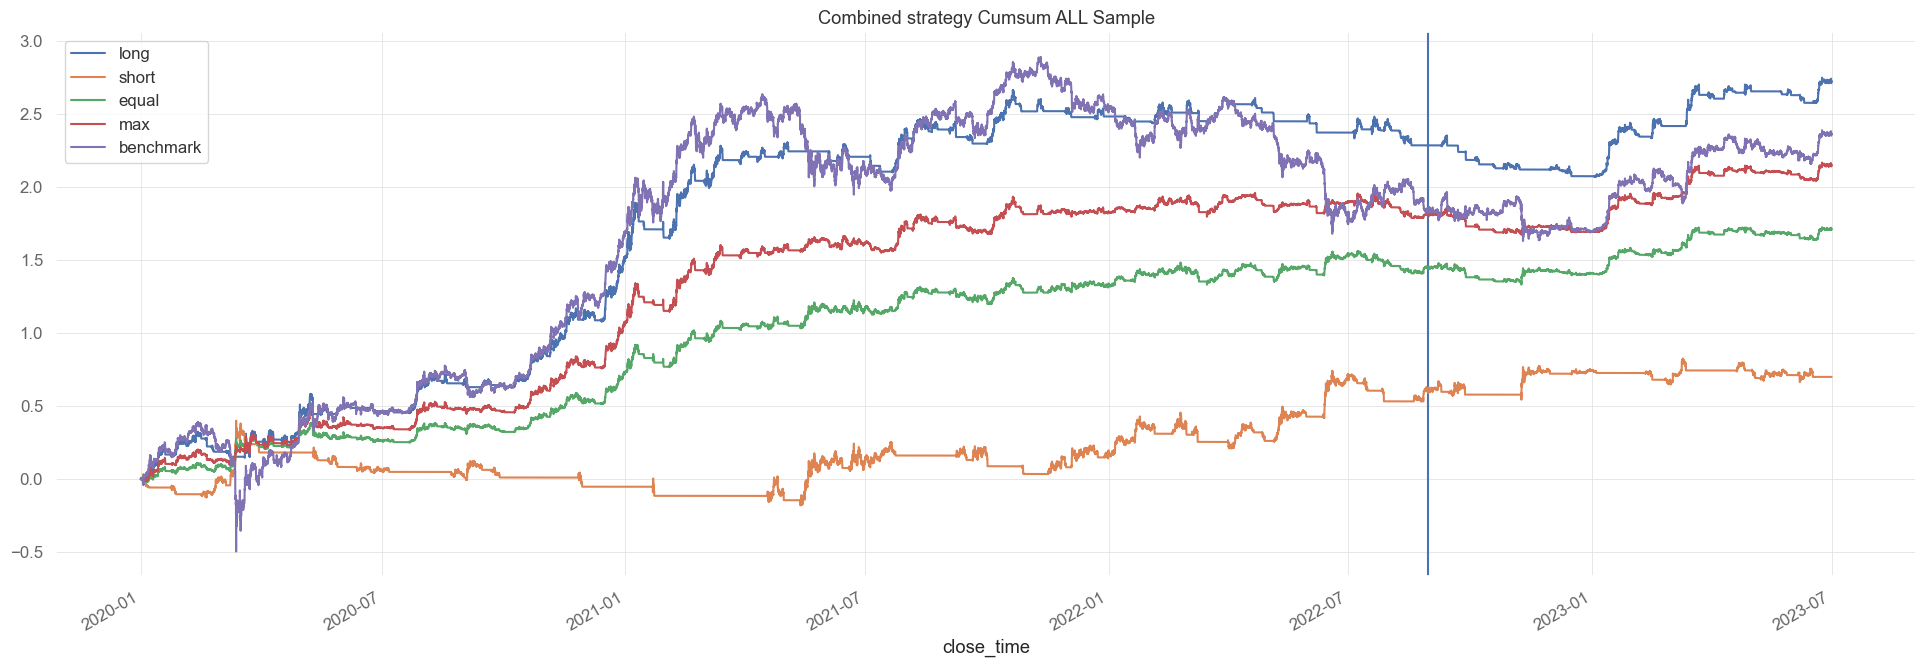

comb_rsi_window          32        33                  32                  49  \
comb_fastk_period        24        25        20        25        17        18   
comb_slowk_period         3         3         3         3         3         3   
comb_slowd_period         3         3         3         3         3         3   
sharpe_weight      0.142914  0.144215  0.144604  0.140685  0.143842  0.058641   

comb_rsi_window                                          
comb_fastk_period        27        26      29        28  
comb_slowk_period         3         3       3         3  
comb_slowd_period         3         3       3         3  
sharpe_weight      0.058414  0.058414  0.0543  0.053973  


In [110]:
demo_df=pd.DataFrame()
demo_df['long']=long_returns.mean(axis=1)
demo_df['short']=short_returns.mean(axis=1)
demo_df['equal']=demo_df['long']*0.5+demo_df['short']*0.5
ls_df=pd.concat([long_returns, short_returns], axis = 1)
max_w = max_sharpe(ls_df.loc[:train_end])
demo_df['max'] =  (ls_df*max_w.values).sum(axis = 1)
demo_df[BENCHMARK]=data['close'].pct_change()
demo_df.index = pd.to_datetime(demo_df.index)
plot_cumsum(demo_df.loc[:train_end].cumsum(), title = 'Combined strategy Cumsum In Sample')
plot_cumsum(demo_df.loc[train_end:].cumsum(), title = 'Combined strategy Cumsum Out Sample')
plot_cumsum(demo_df.cumsum(), title = 'Combined strategy Cumsum ALL Sample')
print(max_w)

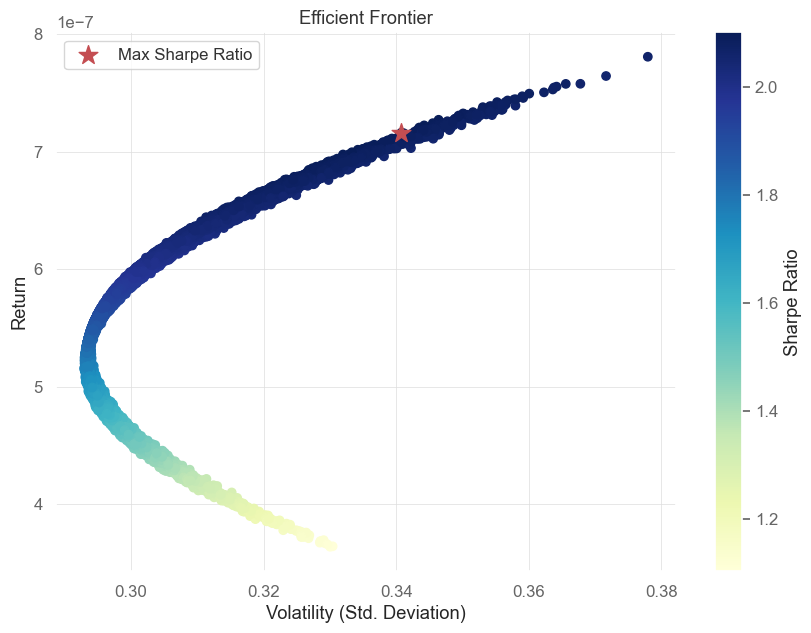

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 假設 demo_ret 是你的資產回報率數據集
UPPER_WEIGHT = 0.5

def max_sharpe(demo_ret):
    def efficient_frontier(expected_returns, cov_matrix, risk_free_rate):
        num_assets = len(expected_returns)
        initial_weights = np.ones(num_assets) / num_assets  # 初始權重平均分配

        constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(np.abs(weights)) - 1})  # 權重和為1

        bounds = tuple((0.05, UPPER_WEIGHT) for _ in range(num_assets))  # 權重邊界限制
        result = minimize(objective, initial_weights, args=(expected_returns, cov_matrix, risk_free_rate),
                          method='SLSQP', bounds=bounds, constraints=constraints)

        efficient_weights = result.x
        return efficient_weights

    def objective(weights, expected_returns, cov_matrix, risk_free_rate):
        portfolio_return = np.sum(expected_returns * weights)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std
        return -sharpe_ratio  # 最小化Sharpe比率的負值來最大化它

    risk_free_rate = 0
    cov_matrix = demo_ret.cov().values
    sharp_weight = efficient_frontier(demo_ret.mean().values, cov_matrix, risk_free_rate)
    sharp_weight = pd.DataFrame(sharp_weight, index=demo_ret.columns, columns=['sharpe_weight']).T
    return sharp_weight

# 定義不同的投資組合權重
def portfolio_performance(weights, expected_returns, cov_matrix):
    portfolio_return = np.sum(weights * expected_returns)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_std

def efficient_frontier(demo_ret, num_portfolios=100000):
    expected_returns = demo_ret.mean().values
    cov_matrix = demo_ret.cov().values
    risk_free_rate = 0

    results = np.zeros((3, num_portfolios))
    weights_record = []

    for i in range(num_portfolios):
        weights = np.random.uniform(0.05, UPPER_WEIGHT, len(expected_returns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_return, portfolio_std = portfolio_performance(weights, expected_returns, cov_matrix)
        results[0,i] = portfolio_std * 100  # 將波動率調整為正確量級
        results[1,i] = portfolio_return / 100  # 調整回報率
        results[2,i] = ((portfolio_return - risk_free_rate) / portfolio_std) * 100  # 調整 Sharpe 比率

    return results, weights_record

# 計算效率前緣
results, weights_record = efficient_frontier(ls_df)

# 找到最大Sharpe比率的位置
max_sharpe_idx = np.argmax(results[2])
sdp_max, rp_max = results[0,max_sharpe_idx], results[1,max_sharpe_idx]

# 繪製效率前緣
plt.figure(figsize=(10, 7))
plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(sdp_max, rp_max, marker='*', color='r', s=200, label='Max Sharpe Ratio')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Return')
plt.legend(labelspacing=0.8)
plt.show()


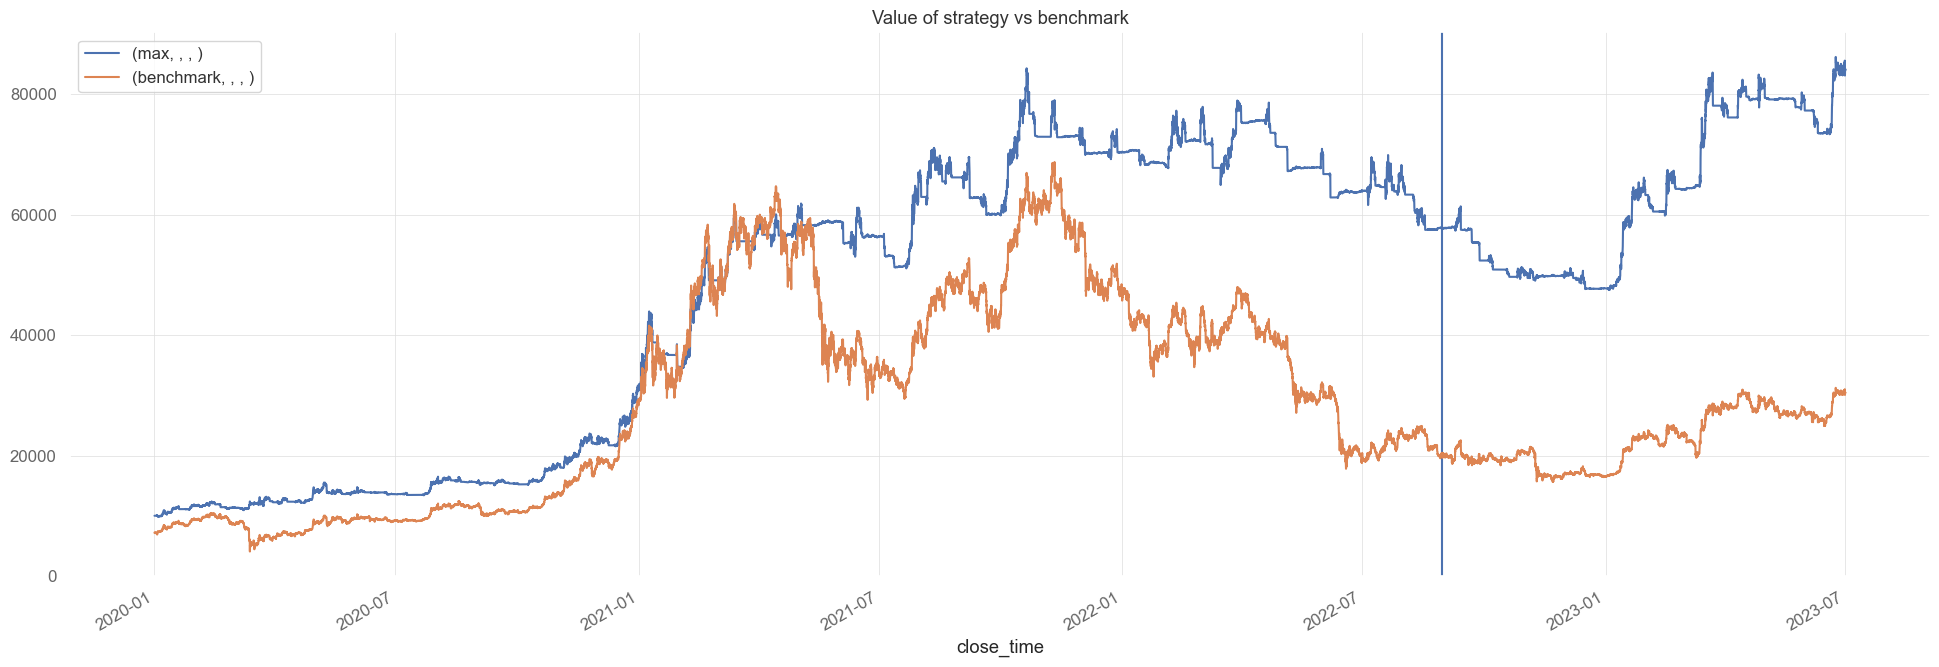

In [111]:
show_df=(ls_df+1).cumprod()*max_w.values*10000
show_df['max'] =show_df.sum(axis=1)
show_df['benchmark'] = data['close']
plot_cumsum(show_df.iloc[:,-2:], title='Value of strategy vs benchmark')

In [112]:
def two_profit(df, title = 'title'):
    col1 = df.columns[0]
    col2 = df.columns[1]


    def calculate_drawdown(series):
        high_water_mark = series.cummax()
        drawdown = series - high_water_mark
        return drawdown

    df['drawdown'] = calculate_drawdown(df[col1])
    high_points = df[col1].cummax()
    new_high = df[df[col1] == high_points][col1]
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), dpi=200, sharex=True)
    color_1 = '#1f77b4'
    color_2 = '#ff7f0e'
    color_drawdown = '#d62728'
    color_high = '#00FF00'


    ax1.plot(df.index, df[col1], label=col1, color=color_1)
    ax1.plot(df.index, df[col2], label=col2, color=color_2,alpha = 0.6)
    ax1.set_title(title, fontsize=16, fontweight='bold')
    ax1.axvline(x= pd.to_datetime(train_end) , ymin=0, ymax=4.5)
    # ax1.set_ylabel('Value', fontsize=14)
    ax1.legend(loc='upper left', fontsize='small')


    ax2.plot(df.index, df[col1], label=col1, color=color_1)
    ax2.fill_between(df.index, df['drawdown'], 0, color=color_drawdown, alpha=0.5, label='Drawdown')
    ax2.scatter(new_high.index, new_high, color=color_high, label='High', zorder=5, alpha = 0.4)
    ax2.set_title('Drawdown', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=14)
    ax2.axvline(x= pd.to_datetime(train_end) , ymin=0, ymax=4.5)
    # ax2.set_ylabel('Value', fontsize=14)
    ax2.legend(loc='upper left', fontsize='small')


    for ax in [ax1, ax2]:
        ax.grid(True)
        # ax.set_facecolor('whitesmoke')
        ax.tick_params(axis='x', labelsize=12, rotation=45)
        ax.tick_params(axis='y', labelsize=12)
    plt.tight_layout()
    plt.show()
    df = df.drop(columns = 'drawdown')


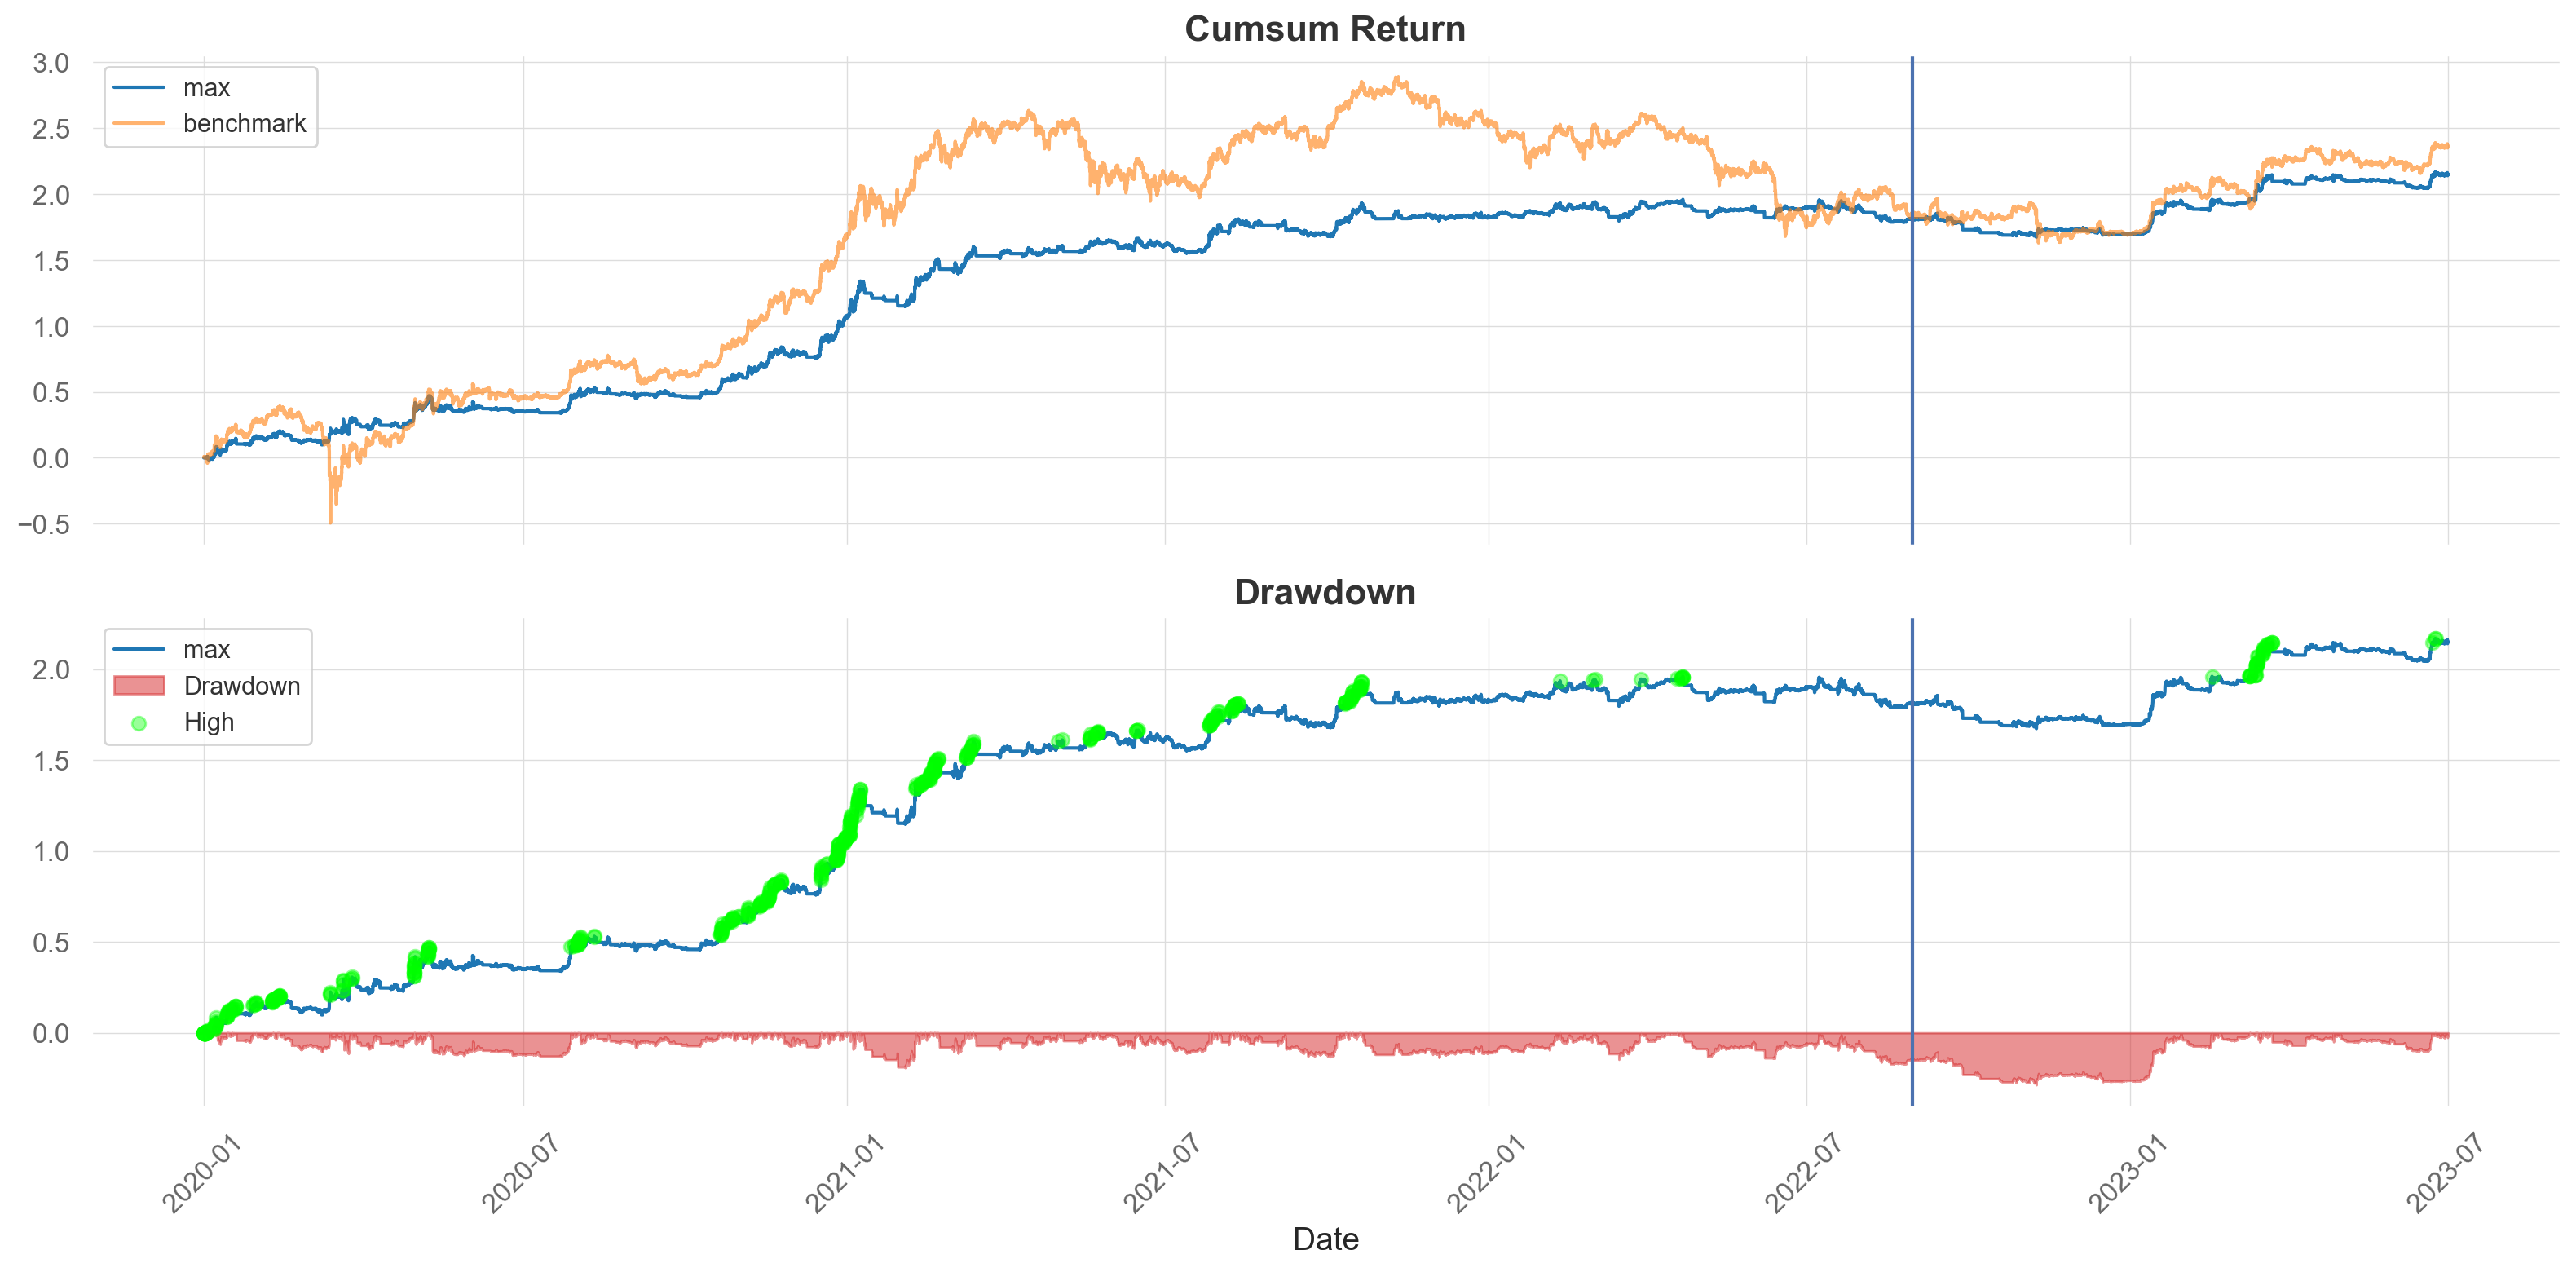

In [156]:
two_profit(demo_df[['max',BENCHMARK]].cumsum(), title = 'Cumsum Return')

In [114]:
import quantstats as qs
ANNUAL_MULTI = 365*24

def eveluate(sp_strats, benchmark, name):
    df_metrics = pd.DataFrame()
    for col in sp_strats.columns:
        if col == benchmark:
            df_metrics[col] = qs.reports.metrics(sp_strats[benchmark], mode='full', periods_per_year = ANNUAL_MULTI, display=False)
        else:
            df_metrics[col]= qs.reports.metrics(sp_strats[col], mode='full',
                                                display=False,
                                                periods_per_year = ANNUAL_MULTI,
                                                benchmark=sp_strats[benchmark])['Strategy']
    df_metrics.columns = [ i + "%s"%name for i in df_metrics.columns]
    return df_metrics


In [ ]:
df_metrics_in = eveluate(demo_df.loc[:train_end], benchmark = BENCHMARK, name = '_in')
df_metrics_out = eveluate(demo_df.loc[train_end:], benchmark = BENCHMARK, name = '_out')
df_metrics_all = eveluate(demo_df, benchmark = BENCHMARK, name = '_all')
df_metrics = pd.concat([df_metrics_in, df_metrics_out, df_metrics_all], axis=1)

In [103]:
df_metrics.head(60)

,long_in,short_in,equal_in,max_in,benchmark_in,long_out,short_out,equal_out,max_out,benchmark_out,long_all,short_all,equal_all,max_all,benchmark_all
Start Period,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2022-08-30,2022-08-30,2022-08-30,2022-08-30,2022-08-30,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01
End Period,2022-08-30,2022-08-30,2022-08-30,2022-08-30,2022-08-30,2023-06-30,2023-06-30,2023-06-30,2023-06-30,2023-06-30,2023-06-30,2023-06-30,2023-06-30,2023-06-30,2023-06-30
Risk-Free Rate,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Time in Market,0.47,0.39,0.81,0.81,1.0,0.41,0.41,0.79,0.79,1.0,0.45,0.4,0.8,0.8,1.0
Cumulative Return,6.52,0.5,2.82,4.28,1.76,0.48,0.07,0.29,0.38,0.5,10.17,0.57,3.86,6.22,3.25
CAGR﹪,0.69,0.11,0.42,0.54,0.3,0.39,0.06,0.23,0.3,0.4,0.61,0.09,0.37,0.48,0.33
Sharpe,1.91,0.58,1.86,2.03,0.88,1.64,0.42,1.54,1.71,1.23,1.84,0.53,1.78,1.95,0.94
Prob. Sharpe Ratio,1.0,0.83,1.0,1.0,0.92,0.93,0.65,0.92,0.94,0.87,1.0,0.84,1.0,1.0,0.96
Smart Sharpe,1.91,0.57,1.84,2.02,0.87,1.62,0.42,1.53,1.7,1.22,1.84,0.52,1.76,1.94,0.92
Sortino,2.74,0.86,2.73,2.93,1.23,2.37,0.63,2.26,2.49,1.75,2.65,0.79,2.6,2.82,1.31


In [ ]:
qs.reports.plots(demo_df,mode='full')

In [ ]:
tmp=pd.concat([demo_df['max'],demo_df[BENCHMARK]],axis=1)
qs.reports.plots(tmp,mode='full')